# No Shift Sherlock

### Overview:
This project draws inspiration from 'Would It Dong?' The viral project that uses statcast data to predict how many other MLB parks a home run would have 'donged'.

It uses a ML classifier to look at MLB hits and predict whether they would have been outs against a conventional infield shift (banned in 2022).

### Dependencies:
- pybaseball (https://github.com/jldbc/pybaseball)
- sklearn
    - random forest classifier (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
- pandas
- numpy
- matplotlib

In [263]:
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt

from pybaseball import statcast 
from pybaseball import plotting

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.tree import export_graphviz
from scipy.stats import randint

### Loading the data
- Leverage the pybaseball library to load statcast data from 2018-2021 seasons
    - Statcast era, peak of shifting
- Data is stashed as a pickle

In [ ]:
df = statcast('2018-03-29','2021-10-02', verbose=False) # ultimately do 2018-2022 (regular season), see if you can just do the year
df.to_pickle("./2018_2022_season_statcast.pkl")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
 48%|███████████████████▋                     | 354/738 [04:42<04:37,  1.38it/s]

In [132]:
df = pd.read_pickle("./2018_2022_season_statcast.pkl")  

### Data Cleaning and Feature Engineering
- Check if columns are null
- Filter out outlier events
    - Bunted balls, balls hit to outfield, postseason at-bats
- Create new features
    - Create binary feature that's 1 if the infield is shifted and 0 if not
    - Create binary feature that's 1 if the play results in an out and 0 if not
    - Create a feature for spray angle (0 degrees is second base line, negative angle is left, toward third base ;and positive angle is right, toward first base

In [175]:
def check_null(df):
    # Drop events without infield fielding data, launch speed, launch_angle, hc_x, and hc_y
    df = df[pd.notnull(df['if_fielding_alignment'])]
    df = df[pd.notnull(df['launch_speed'])]
    df = df[pd.notnull(df['launch_angle'])]
    df = df[pd.notnull(df['hc_x'])]
    df = df[pd.notnull(df['hc_y'])]
    return df


def filter_columns(df):
    # Filter out postseason at bats
    df = df.loc[df['game_type'] == 'R']
    
    # Drop events where exit_velocy <65 or null (intention is to filter out bunted balls)
    df = df.loc[df['launch_speed'] >= 65]

    # Drop events that were not batted to the infield (popup is a fly ball to the infield)
    valid_bb_type = ['ground_ball', 'line_drive', 'pop-up']
    df = df.loc[df['bb_type'].isin(valid_bb_type)]

    # Drop events that did not produce a hit/out (e.g. pickoffs, wild pitches, etc.)
    valid_events = ['field_out', 'grounded_into_double_play', 'single', 
                    'double', 'force_out', 'triple', 'field_error', 
                    'double_play', 'fielders_choice', 'fielders_choice_out', 
                    'other_out', 'triple_play']
    df = df.loc[df['events'].isin(valid_events)]
    return df


# Helper function to calculate spray angle given x and y coordinates
def caculate_spray_angle(hc_x: float, hc_y: float):
    # Adjusted ratio based on home plate location (125,198)
    adjusted_angle_ratio = (hc_x - 125)/(198 - hc_y)
    return math.atan(adjusted_angle_ratio)*(180/math.pi)


def create_is_shift(df):
    # Create a new feature that is 1 if the infield is shifted and 0 if not
    df['is_shift'] = np.where(df['if_fielding_alignment'] == 'Infield shift', 1, 0)
    return df


def create_is_out(df):
    # Create a new feature that is 1 if the player was out (fielder;s choice = out)
    out_events = ['field_out', 'grounded_into_double_play', 'force_out', 
                    'double_play', 'fielders_choice', 'fielders_choice_out', 
                    'other_out', 'triple_play']
    df['is_out'] = np.where(df['events'].isin(out_events), 1, 0)
    return df

def create_spray_angle(df):
    # Create a new feature spray_angle by calling calculate_spray_angle()
    df['spray_angle'] = df.apply(lambda df: spray_angle(df['hc_x'], df['hc_y']), axis=1)
    return df

In [172]:
df = check_null(df)
df = filter_columns(df)
df = create_is_shift(df)
df = create_is_out(df)
df = create_spray_angle(df)

NameError: name 'check_null' is not defined

### Building the model
- Select features (X) for the model: launch_speed, launch_angle, spray_angle, is_shift
- Classify is_out (y)
- Classification model type is a Random Forest
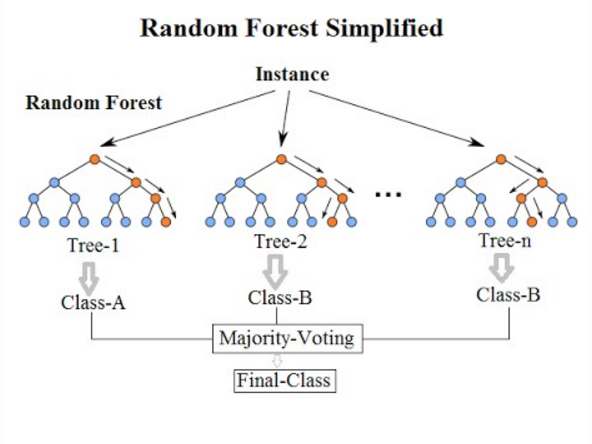
- Split the data using 80/20 split (https://towardsdatascience.com/finally-why-we-use-an-80-20-split-for-training-and-test-data-plus-an-alternative-method-oh-yes-edc77e96295d)

In [144]:
# Split the data into features (X) and target (y)
X = df[['launch_speed', 'launch_angle', 'spray_angle', 'is_shift']].copy()
y = df['is_out']

# Split the data into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Tuning the model
- Use the sklearn randomized search CV to optimize hyperparameters based on attempts to fit and score the model with different parameters
    - n_estimators is the number of trees in the random forest
    - max_depth is the number of splits each decision tree can make
    - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

In [173]:
param_dist = {'n_estimators': randint(50,250),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 14, 'n_estimators': 177}


### Make a Prediction
- Make a prediction on the test data split and evaluate the accuracy
- Visualize the accuracy using a confusion matrix
    - shows what the model predicted against what the correct prediction was. We can use this to understand the tradeoff between false positives (top right) and false negatives(bottom left)

Accuracy(best model): 0.7804010413561477


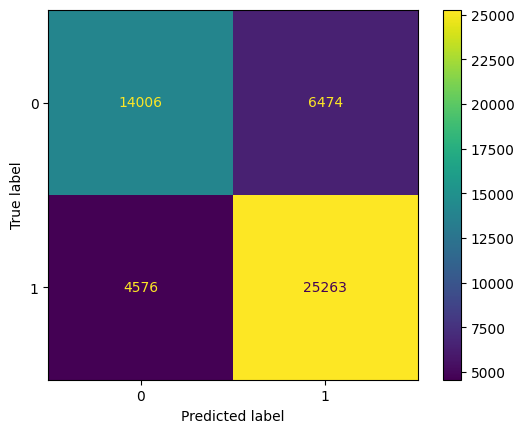

In [169]:
# Use model to make a prediction
y_pred = best_rf.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy(best model):", accuracy)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

# In practice: Evaluating Predictions Against a Day's Worth of Hit Data
Let's put this model into practice by making some predictions against real game events. We'll do this by pulling a day's worth of statcase data.

In [178]:
yesterday_df = statcast(verbose=False)

start_dt 2023-06-26
end_dt 2023-06-27


100%|█████████████████████████████████████████████| 2/2 [00:04<00:00,  2.08s/it]


To maximize the value of this experiment, we're going to use the following function to plot hit location against a standard MLB field. We'll test this by ensuring that our assumed coordindates for home plate (125,198 - which we use in the calculate_spray_angle() function) line up on the model.

/var/folders/1q/387fr5ln7vl9d3rp6r20jx7c0000gn/T/ipykernel_12493/2399101598.py:10: UserWarning: The label '_child6' of <matplotlib.collections.PathCollection object at 0x128567510> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles=[data])


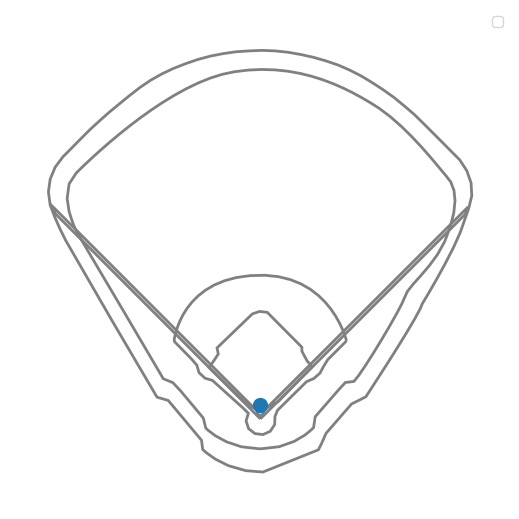

In [262]:
# We'll want to visualize hits to understand which hits cause discrepancies

# Plot the location of a hit
def plot_hit(hc_x: float, hc_y: float, event_name: str='hit'):
    base = plotting.plot_stadium('Royals', title='')
    data = base.scatter(hc_x, 
                        (-1)*hc_y, 
                        100, 
                        label=event_name)
    plt.legend(handles=[data])
    plt.draw()
    plt.show()


# Plot demo - home plate
hc_x = 125
hc_y = 198
plot_hit(hc_x, hc_y, event_name="") 

Next we'll perform nearly identical data cleaning and feature engineering to the dataset as we did to the training data. A notable difference is we only want to look at Standard infielding alignments now, and the 'is_shift' feature should be set to 0 (since there are no shifts).

In [238]:
# Perform same data cleaning and feature engineering tasks
yesterday_df = check_null(yesterday_df)
yesterday_df = filter_columns(yesterday_df)
yesterday_df = create_is_out(yesterday_df)
yesterday_df = create_spray_angle(yesterday_df)
# Shift is always 0 in current data since the shift is banned

# Filter out other infield alignments (e.g. 'Strategic')
df = df.loc[df['if_fielding_alignment'] == 'Standard']
# Goal is to compare to scenarios where infields still shift - and see if there is a discrepancy between outcomes
yesterday_df['is_shift'] = 0

We'll grab the features and make the predictions. Then we'll add a new column to the dataset with the predicted outcome for easier comparison down the lie.

In [239]:
# Select features (X)
yesterday_X = yesterday_df[['launch_speed', 'launch_angle', 'spray_angle', 'is_shift']].copy()

# Use the best random forest classifier (optimized hyperparameters) to make a precition on yesterday's data
yesterday_y_pred = best_rf.predict(yesterday_X)

yesterday_X['is_out_pred'] = yesterday_y_pred

### Comparing Predictions
Now the fun part. We want to iterate over all of the events and find discrepancies between the predicted outcome and the actual outcome. We'll want to visualize this and print the relavant information about the batter/hit.

against shift(predicted): hit | without shift (actual): out
launch_speed: 104.5 , launch_angle: 3


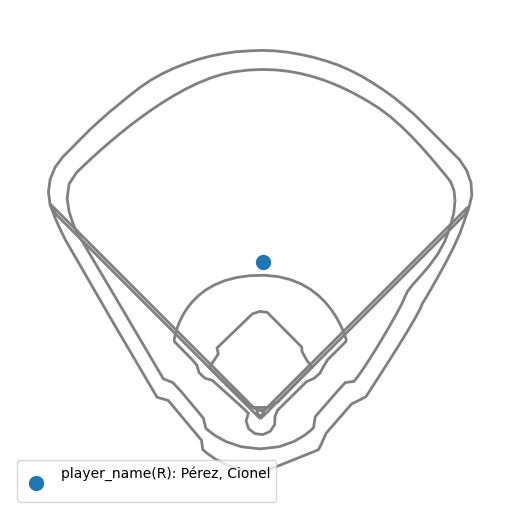

against shift(predicted): out | without shift (actual): hit
launch_speed: 94.7 , launch_angle: -1


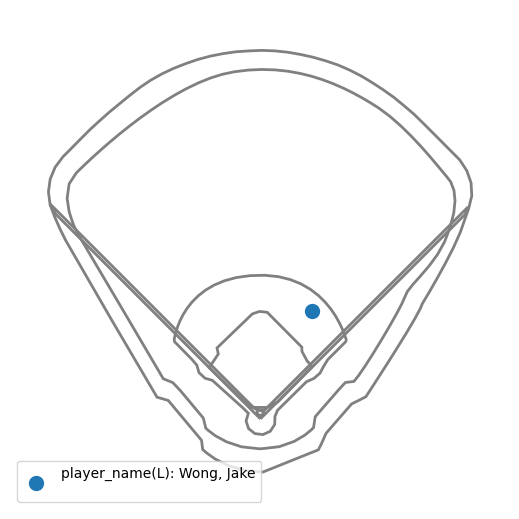

against shift(predicted): hit | without shift (actual): out
launch_speed: 90.4 , launch_angle: 5


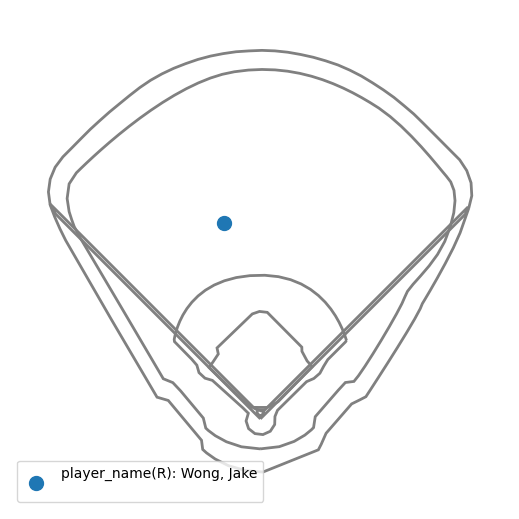

against shift(predicted): out | without shift (actual): hit
launch_speed: 96.6 , launch_angle: -18


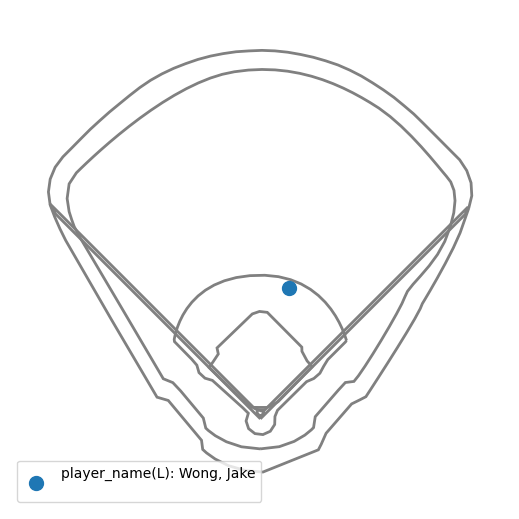

against shift(predicted): out | without shift (actual): hit
launch_speed: 88.4 , launch_angle: 9


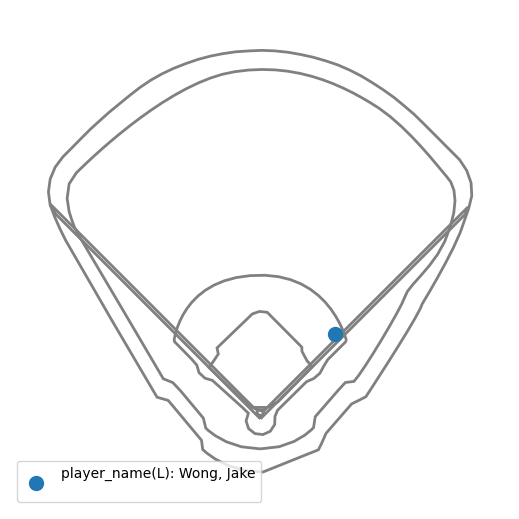

against shift(predicted): out | without shift (actual): hit
launch_speed: 91.0 , launch_angle: -25


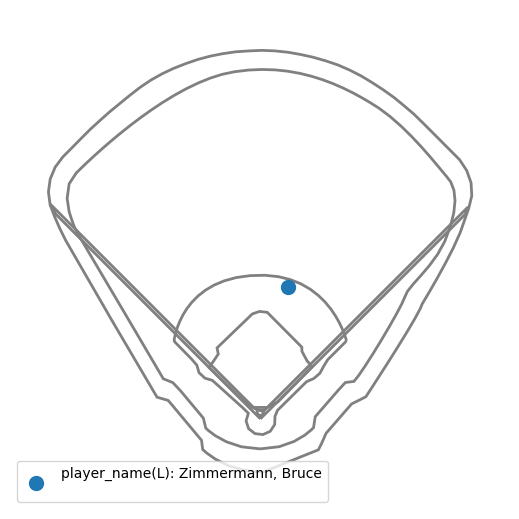

against shift(predicted): out | without shift (actual): hit
launch_speed: 100.7 , launch_angle: -1


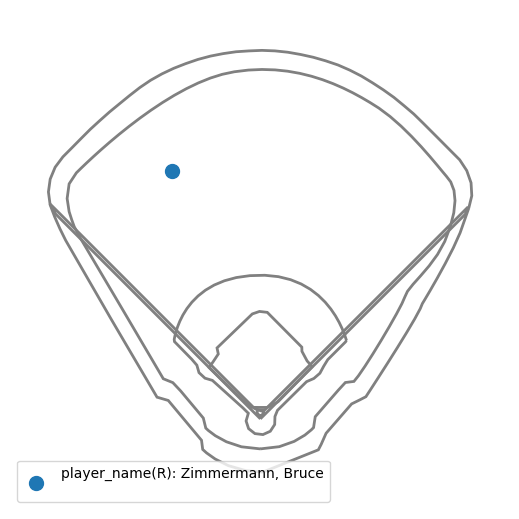

against shift(predicted): out | without shift (actual): hit
launch_speed: 89.2 , launch_angle: 3


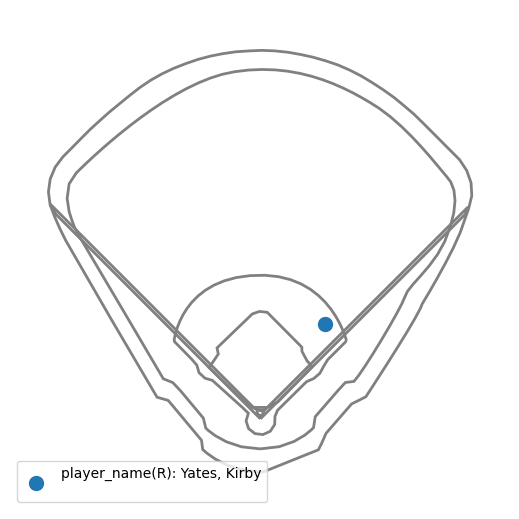

against shift(predicted): out | without shift (actual): hit
launch_speed: 90.9 , launch_angle: -3


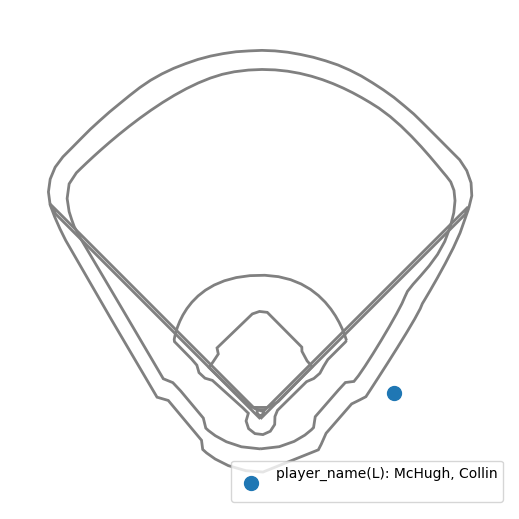

against shift(predicted): hit | without shift (actual): out
launch_speed: 101.0 , launch_angle: 15


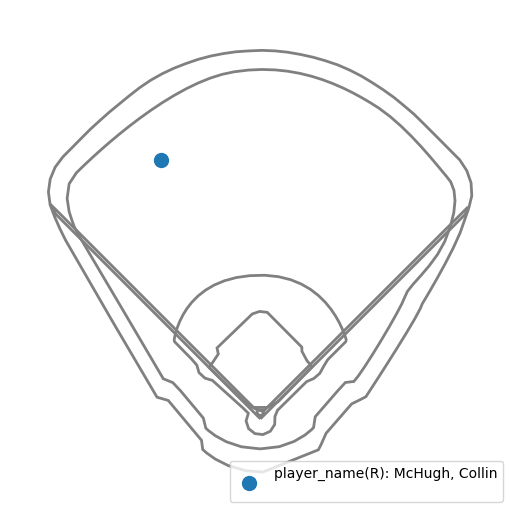

against shift(predicted): out | without shift (actual): hit
launch_speed: 85.0 , launch_angle: 11


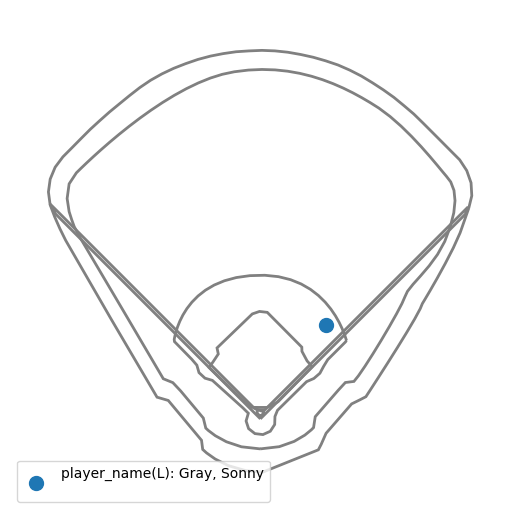

against shift(predicted): hit | without shift (actual): out
launch_speed: 98.7 , launch_angle: -2


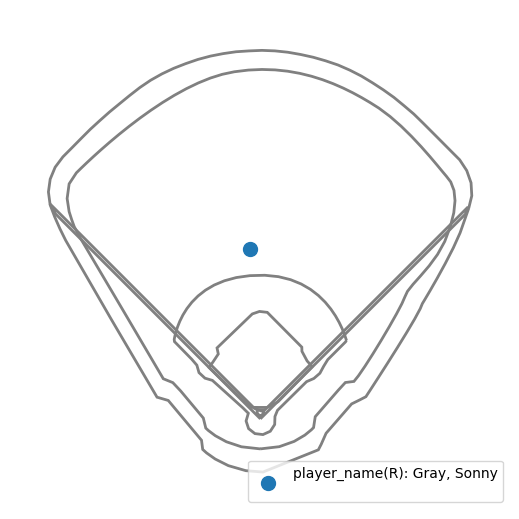

against shift(predicted): out | without shift (actual): hit
launch_speed: 104.0 , launch_angle: 2


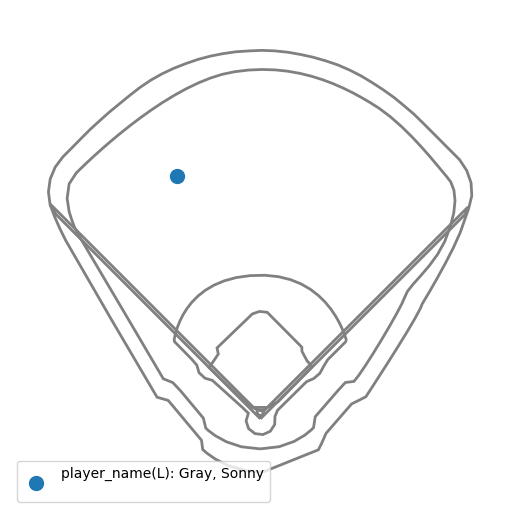

against shift(predicted): hit | without shift (actual): out
launch_speed: 99.1 , launch_angle: 11


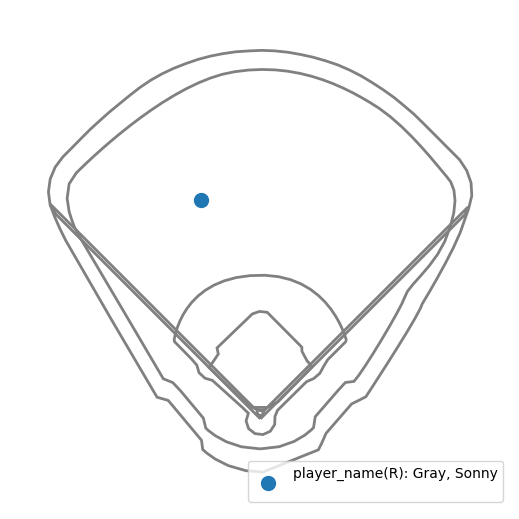

against shift(predicted): out | without shift (actual): hit
launch_speed: 98.3 , launch_angle: 22


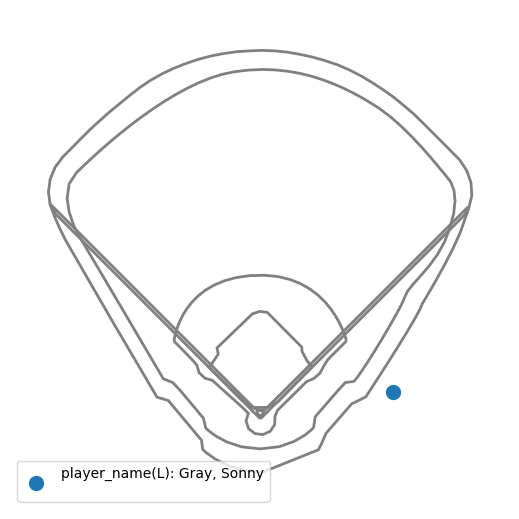

against shift(predicted): hit | without shift (actual): out
launch_speed: 90.2 , launch_angle: 23


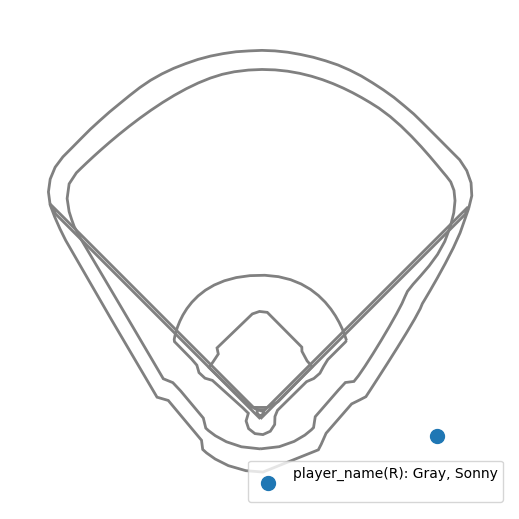

against shift(predicted): out | without shift (actual): hit
launch_speed: 94.1 , launch_angle: -1


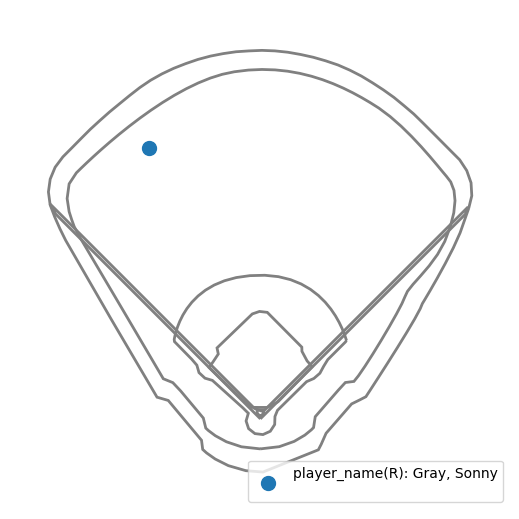

against shift(predicted): hit | without shift (actual): out
launch_speed: 107.3 , launch_angle: 14


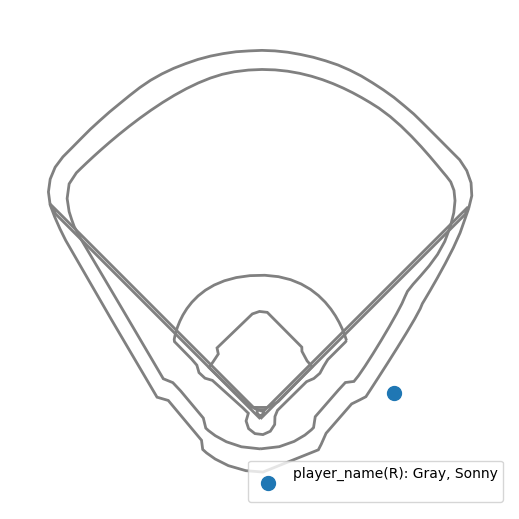

against shift(predicted): hit | without shift (actual): out
launch_speed: 100.6 , launch_angle: 18


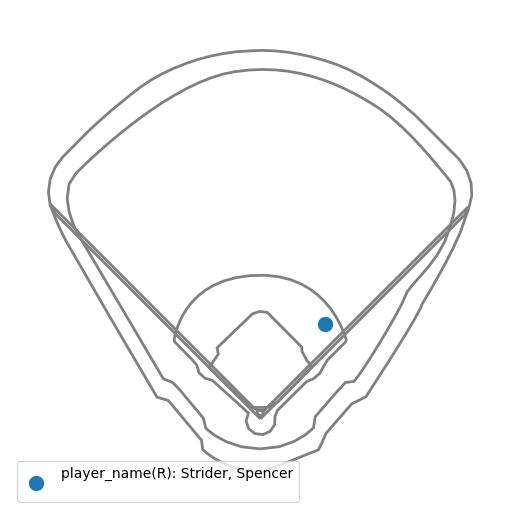

against shift(predicted): hit | without shift (actual): out
launch_speed: 94.4 , launch_angle: 5


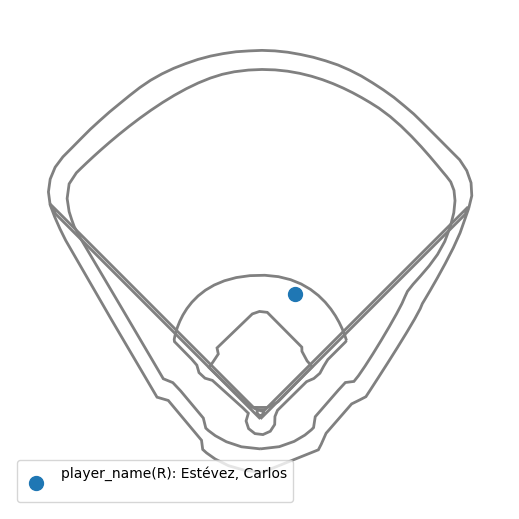

against shift(predicted): hit | without shift (actual): out
launch_speed: 94.5 , launch_angle: 9


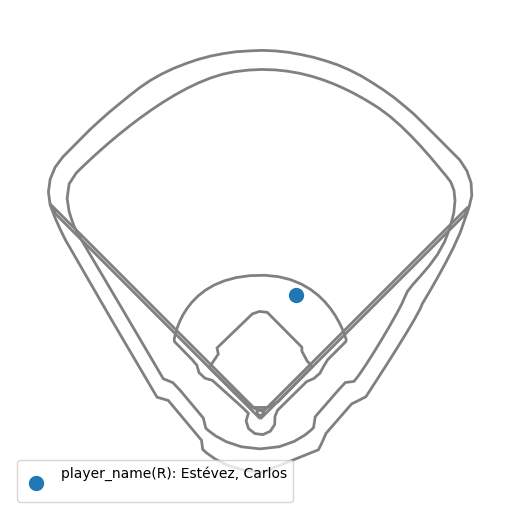

against shift(predicted): out | without shift (actual): hit
launch_speed: 96.5 , launch_angle: 8


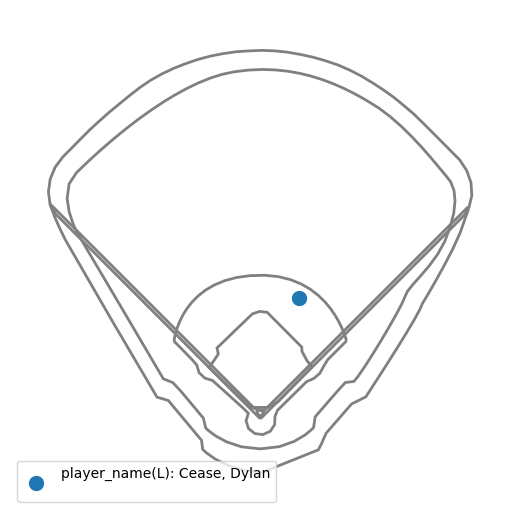

against shift(predicted): out | without shift (actual): hit
launch_speed: 100.9 , launch_angle: -7


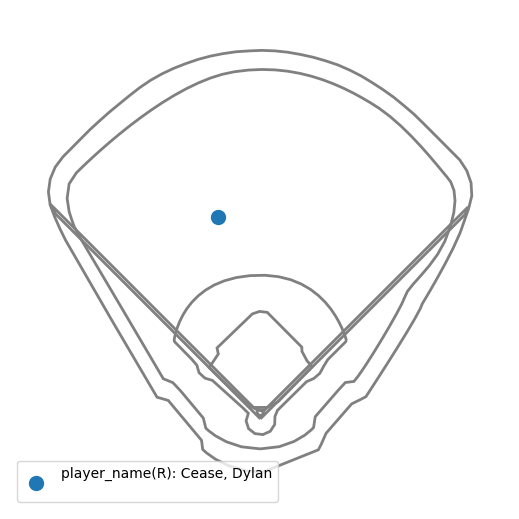

against shift(predicted): hit | without shift (actual): out
launch_speed: 89.4 , launch_angle: 2


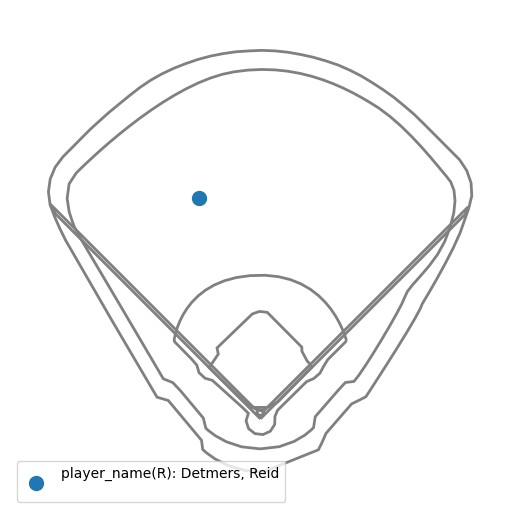

against shift(predicted): out | without shift (actual): hit
launch_speed: 101.2 , launch_angle: -3


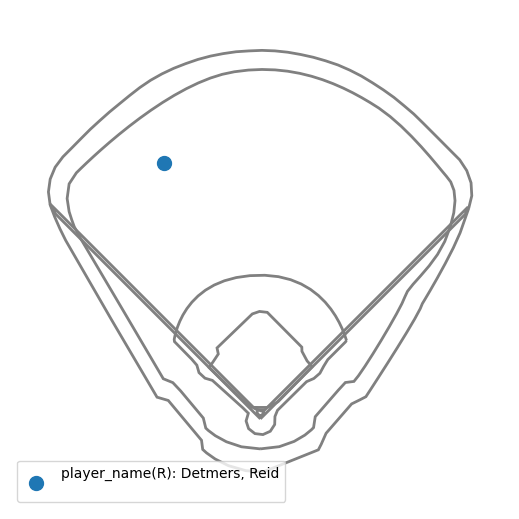

against shift(predicted): hit | without shift (actual): out
launch_speed: 96.4 , launch_angle: 15


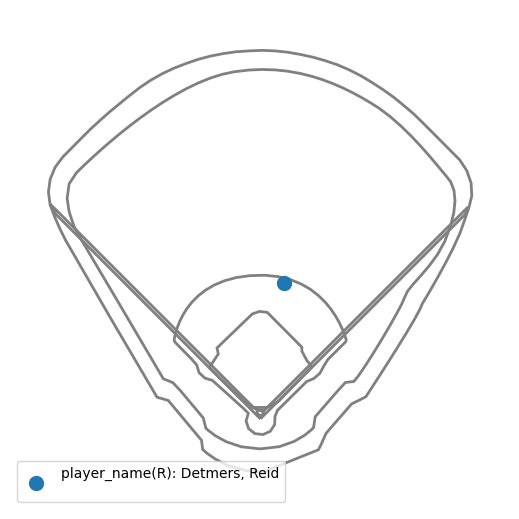

against shift(predicted): hit | without shift (actual): out
launch_speed: 92.8 , launch_angle: 17


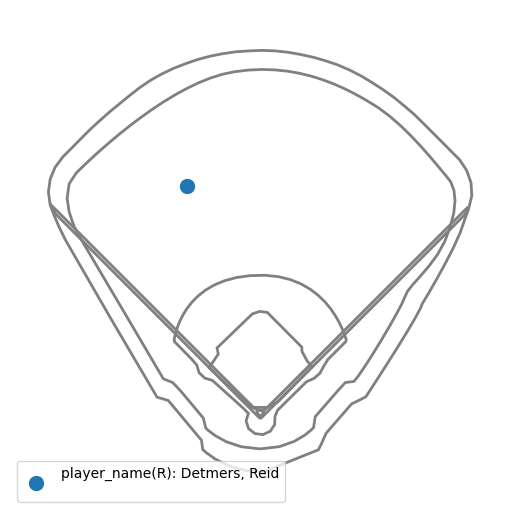

against shift(predicted): hit | without shift (actual): out
launch_speed: 103.2 , launch_angle: 4


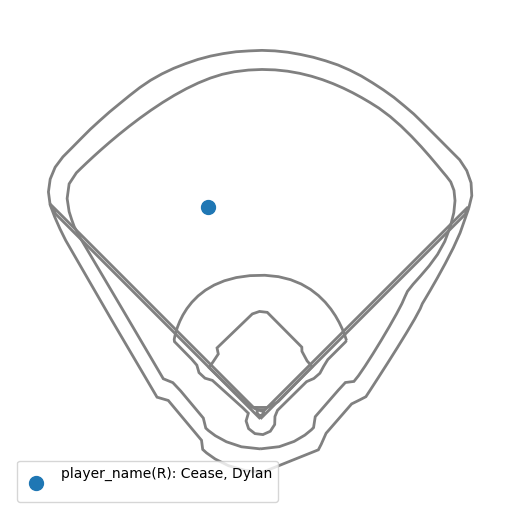

against shift(predicted): out | without shift (actual): hit
launch_speed: 102.6 , launch_angle: 2


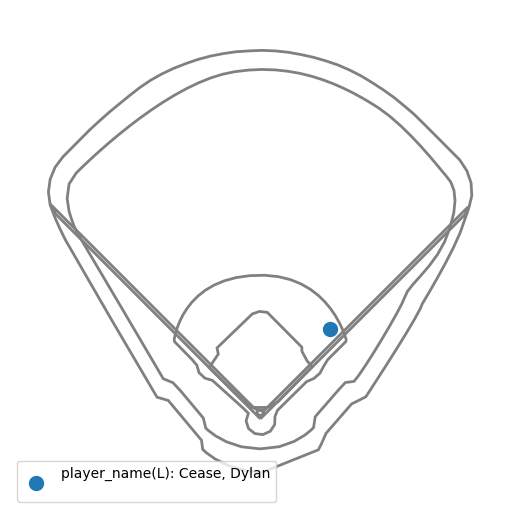

against shift(predicted): hit | without shift (actual): out
launch_speed: 75.7 , launch_angle: 14


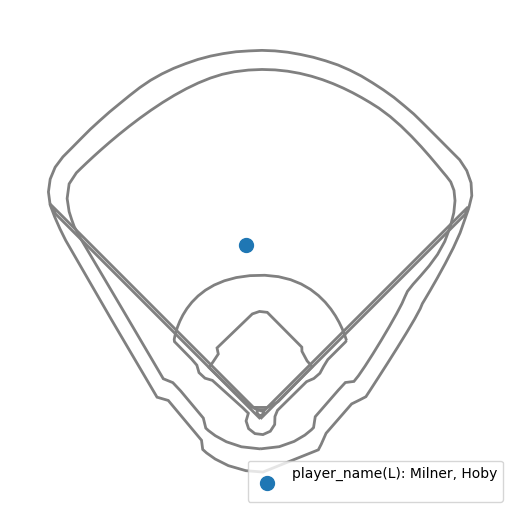

against shift(predicted): hit | without shift (actual): out
launch_speed: 92.3 , launch_angle: 16


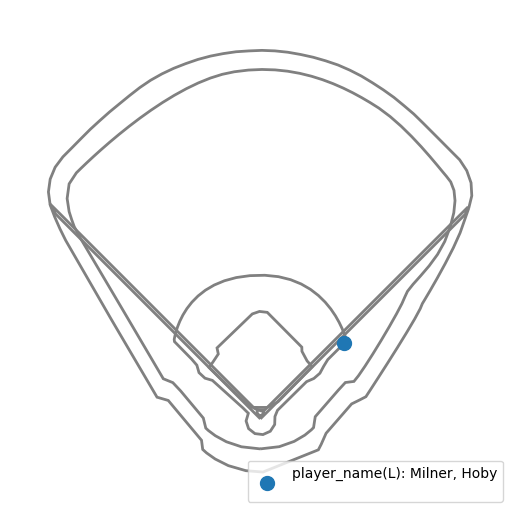

against shift(predicted): hit | without shift (actual): out
launch_speed: 85.6 , launch_angle: 10


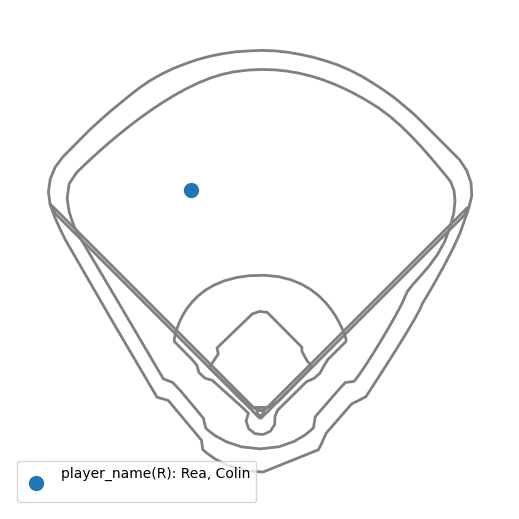

against shift(predicted): hit | without shift (actual): out
launch_speed: 108.8 , launch_angle: 14


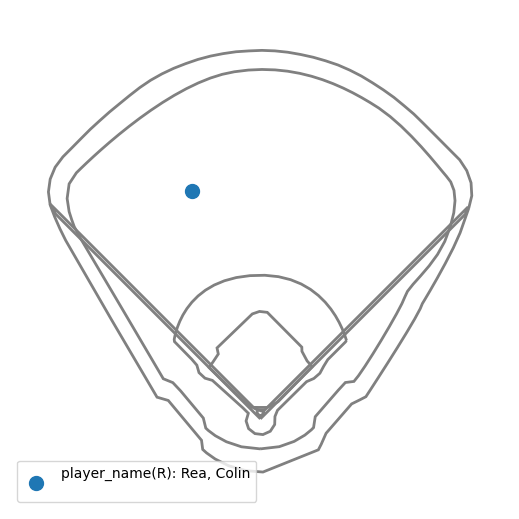

against shift(predicted): out | without shift (actual): hit
launch_speed: 100.8 , launch_angle: 17


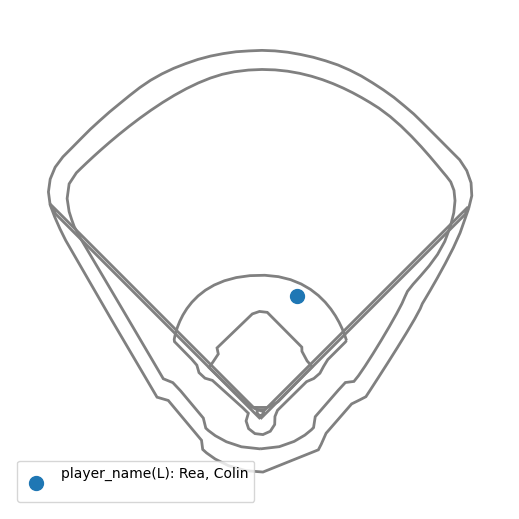

against shift(predicted): out | without shift (actual): hit
launch_speed: 95.2 , launch_angle: 1


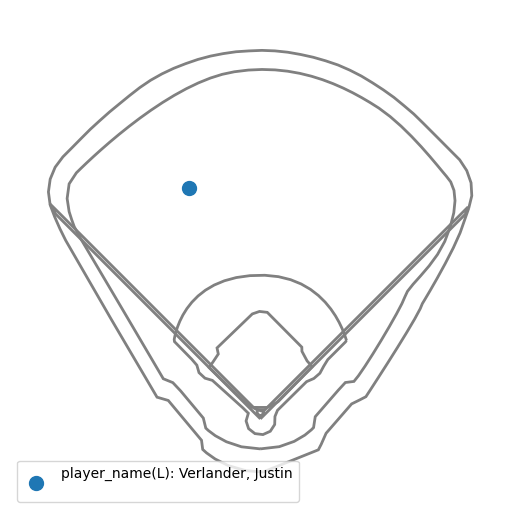

against shift(predicted): hit | without shift (actual): out
launch_speed: 111.8 , launch_angle: 2


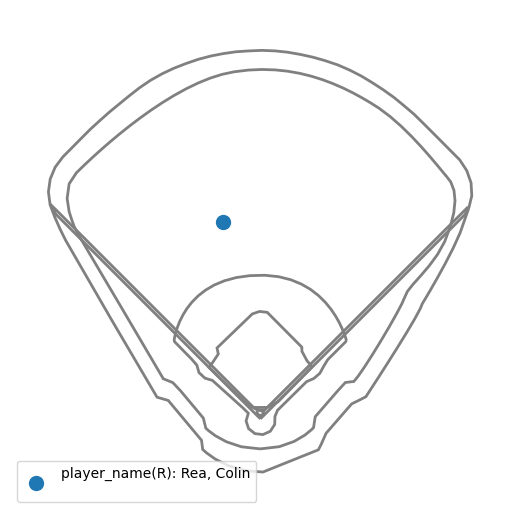

against shift(predicted): out | without shift (actual): hit
launch_speed: 86.3 , launch_angle: 9


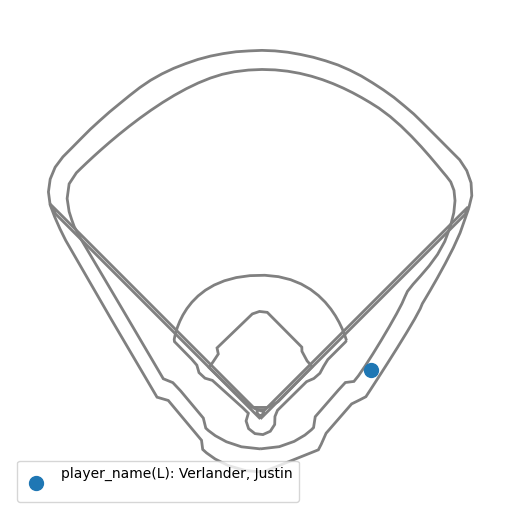

against shift(predicted): out | without shift (actual): hit
launch_speed: 91.1 , launch_angle: 0


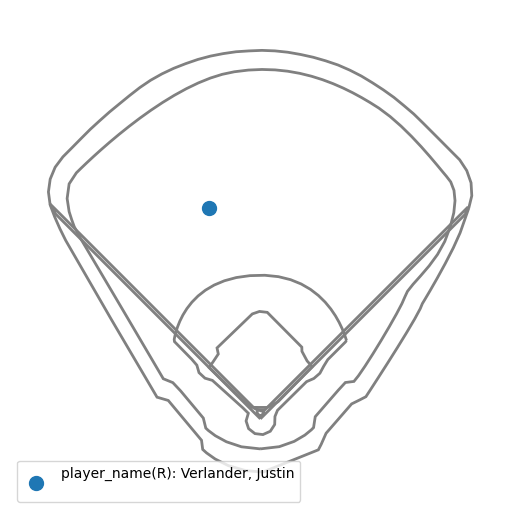

against shift(predicted): out | without shift (actual): hit
launch_speed: 102.0 , launch_angle: -19


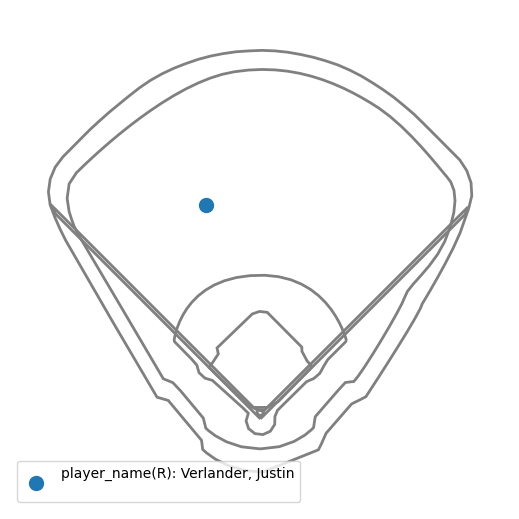

against shift(predicted): out | without shift (actual): hit
launch_speed: 107.5 , launch_angle: -3


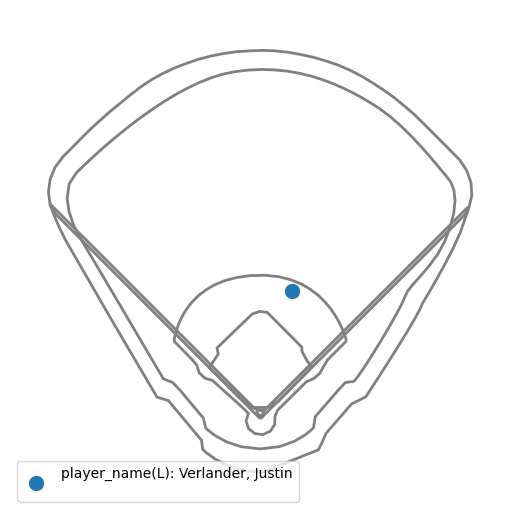

against shift(predicted): out | without shift (actual): hit
launch_speed: 96.5 , launch_angle: -16


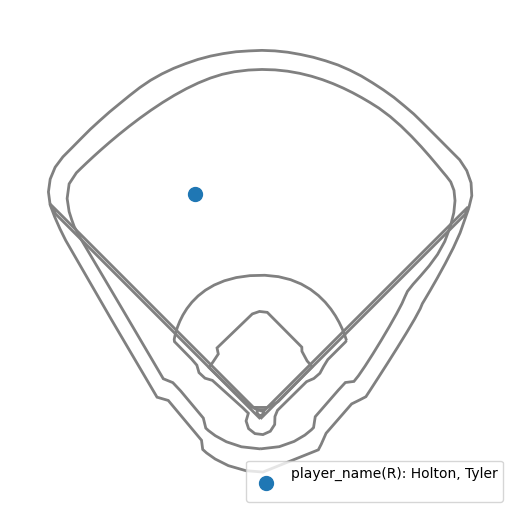

against shift(predicted): hit | without shift (actual): out
launch_speed: 93.3 , launch_angle: 3


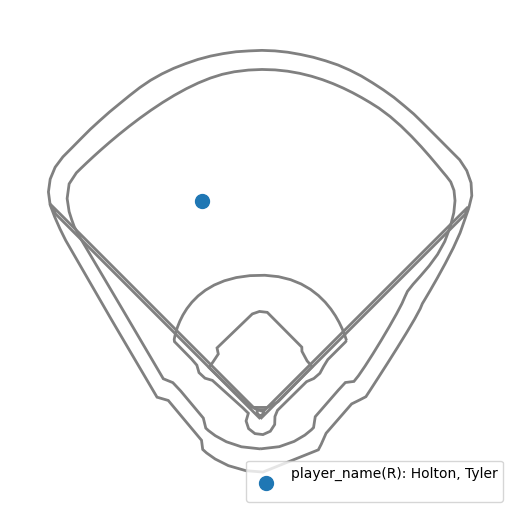

against shift(predicted): hit | without shift (actual): out
launch_speed: 105.9 , launch_angle: 5


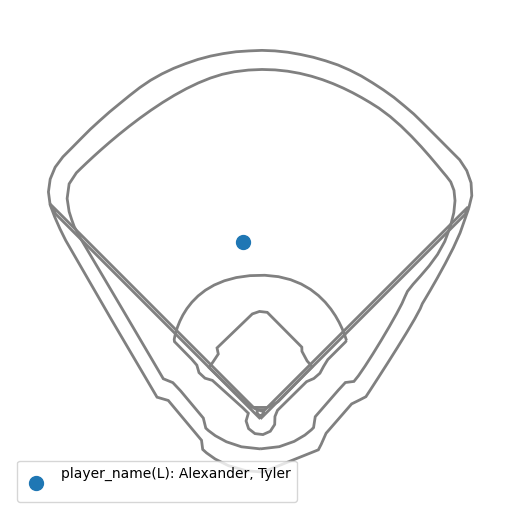

against shift(predicted): out | without shift (actual): hit
launch_speed: 101.6 , launch_angle: 8


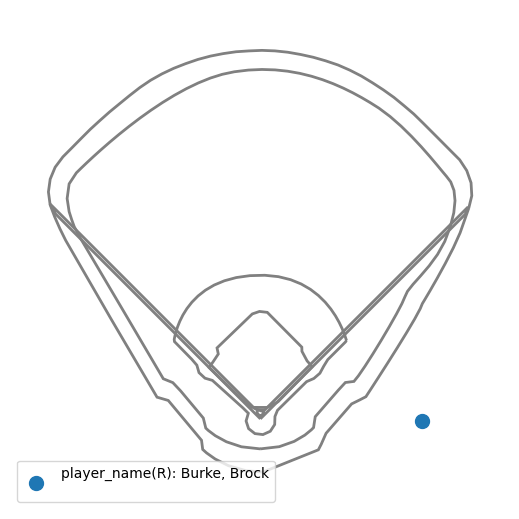

against shift(predicted): out | without shift (actual): hit
launch_speed: 70.7 , launch_angle: -72


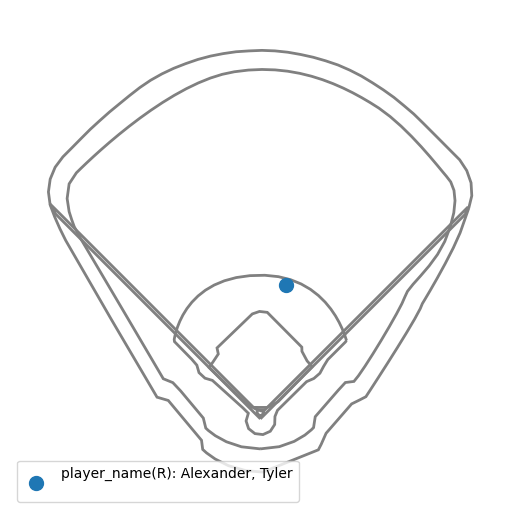

against shift(predicted): hit | without shift (actual): out
launch_speed: 83.6 , launch_angle: 1


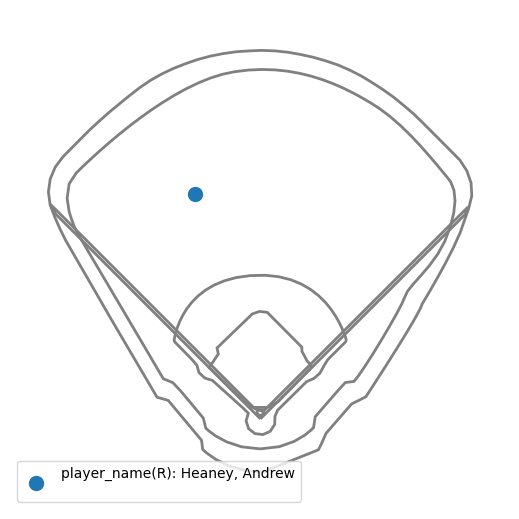

against shift(predicted): hit | without shift (actual): out
launch_speed: 94.0 , launch_angle: 7


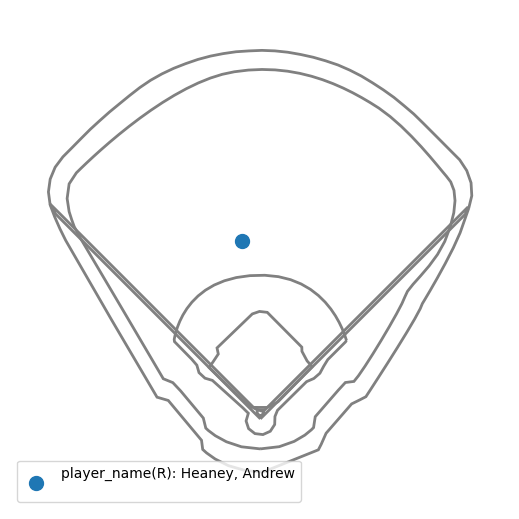

against shift(predicted): out | without shift (actual): hit
launch_speed: 95.9 , launch_angle: -5


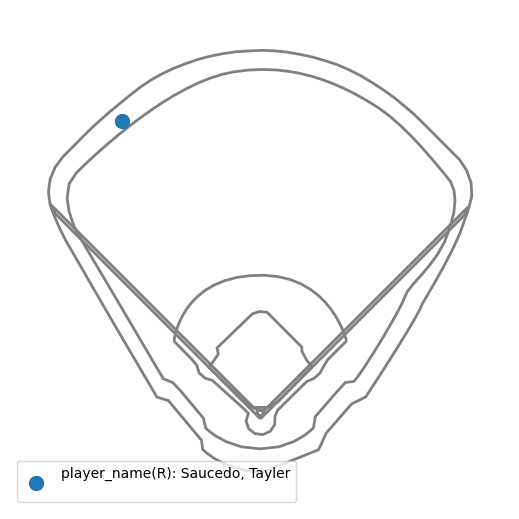

against shift(predicted): hit | without shift (actual): out
launch_speed: 100.8 , launch_angle: 22


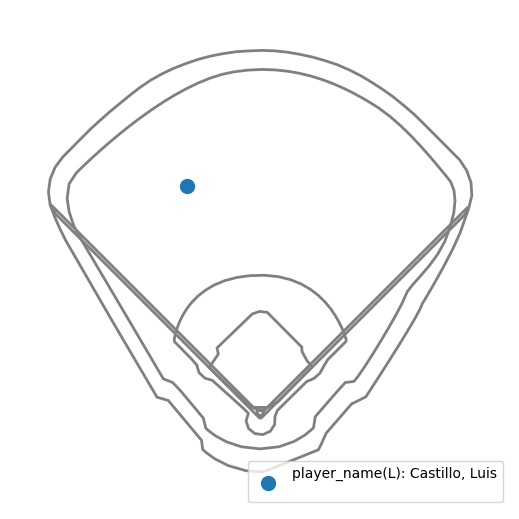

against shift(predicted): out | without shift (actual): hit
launch_speed: 96.7 , launch_angle: 2


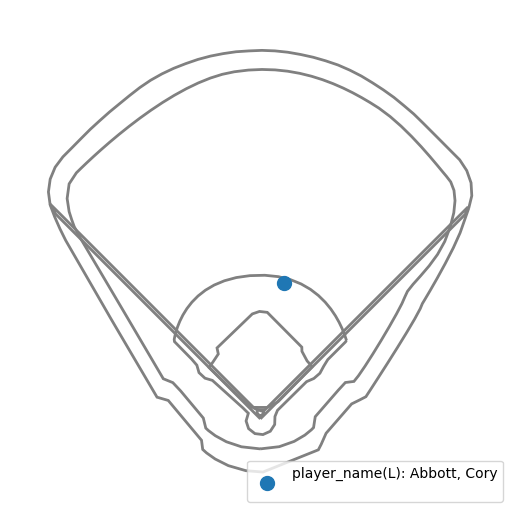

against shift(predicted): out | without shift (actual): hit
launch_speed: 83.9 , launch_angle: -1


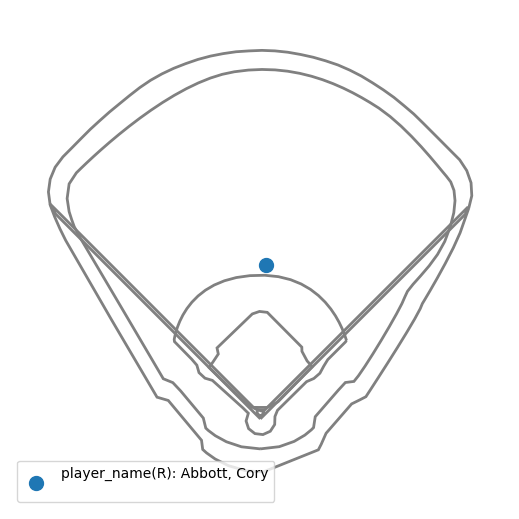

against shift(predicted): hit | without shift (actual): out
launch_speed: 93.3 , launch_angle: 11


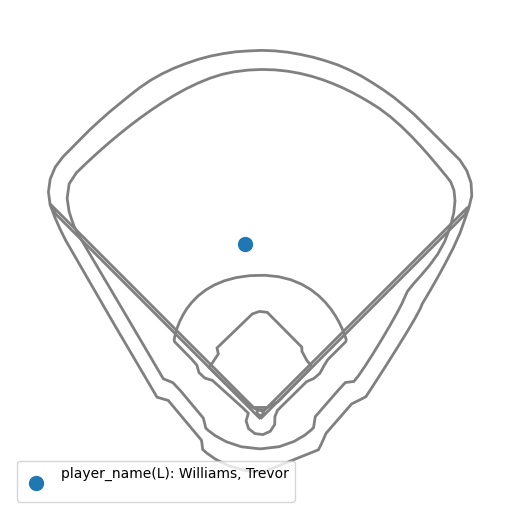

against shift(predicted): out | without shift (actual): hit
launch_speed: 87.1 , launch_angle: -12


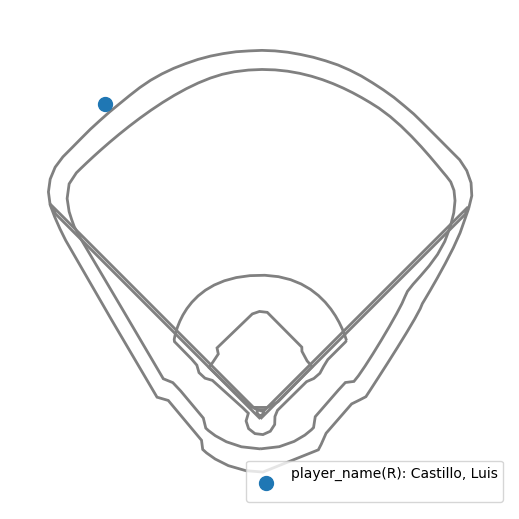

against shift(predicted): out | without shift (actual): hit
launch_speed: 105.0 , launch_angle: 7


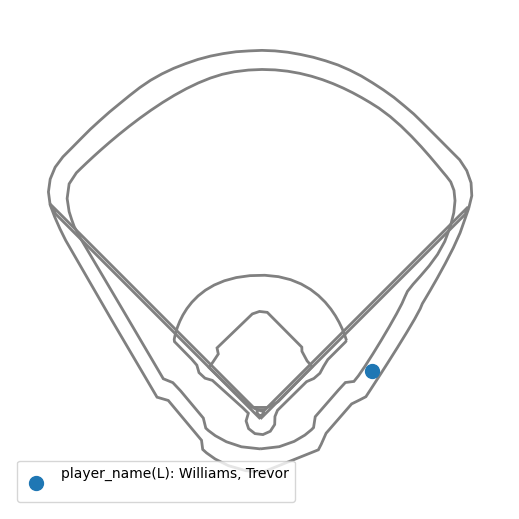

against shift(predicted): out | without shift (actual): hit
launch_speed: 73.9 , launch_angle: 10


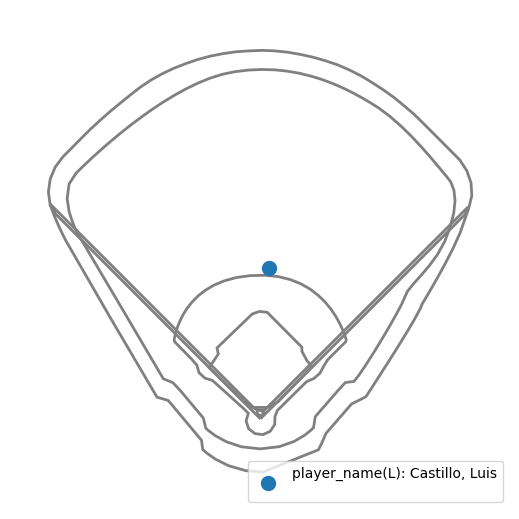

against shift(predicted): out | without shift (actual): hit
launch_speed: 85.0 , launch_angle: -34


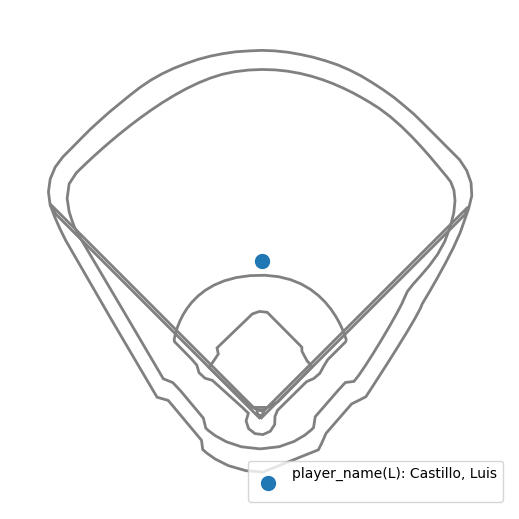

In [256]:
def is_out_str(is_out):
    if is_out == 1:
        return 'out'
    return 'hit'


def pred_actual_discrepancy(prediction, is_out):
    if prediction != is_out:
        return True
    return False


for index, row in yesterday_X.iterrows():
    yd_row = yesterday_df.loc[index]
    pred = row['is_out_pred']
    actual = yd_row['is_out']
    
    if pred_actual_discrepancy(pred, actual):
        event_info = "player_name(%s): %s\n" % (yd_row['stand'], yd_row['player_name'])
        print("against shift(predicted):",is_out_str(pred),"|","without shift (actual):",is_out_str(actual))
        print("launch_speed:",row['launch_speed'],",","launch_angle:",row['launch_angle'])
        plot_hit(yd_row['hc_x'], yd_row['hc_x'], event_info)

In this format, some of the plots come out a bit inconsistent. But overall the results are interesting.

# Conclusion:

This project explored an iteresting question: what impact does banning the shift have on offense. This model can be vastly improved upone by exploring different models and optimizing those models with various features. The data could be further optimized; the visualization helps us see that the mode is picking out events that have nothing to do with the infield. However, there are some instances (especially with left handed batters) where it's as clear as day the impact this rule change has had.